In [1]:
print("Setup is finally working")

Setup is finally working


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("Libraries loaded")

Libraries loaded


In [3]:
df = pd.read_csv("../data/raw/sales.csv")
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
import os
os.getcwd()

'/Users/pranityadav/Documents/retail-demand-forecasting/notebooks'

In [5]:
os.listdir("..")

['.DS_Store', 'venv', 'data', 'notebooks']

In [6]:
print("Notebook is running")

Notebook is running


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

print("Libraries imported")

Libraries imported


In [8]:
os.getcwd()

'/Users/pranityadav/Documents/retail-demand-forecasting/notebooks'

In [9]:
os.listdir("..")

['.DS_Store', 'venv', 'data', 'notebooks']

In [10]:
os.listdir("..")

['.DS_Store', 'venv', 'data', 'notebooks']

In [11]:
os.listdir("..")


['.DS_Store', 'venv', 'data', 'notebooks']

In [12]:
import os
os.listdir("..")

['.DS_Store', 'venv', 'data', 'notebooks']

In [13]:
os.listdir("../data/raw")

['sales.csv']

In [14]:
import pandas as pd

df = pd.read_csv("../data/raw/sales.csv")
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [15]:
df.shape

(913000, 4)

In [16]:
df.columns

Index(['date', 'store', 'item', 'sales'], dtype='str')

In [17]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [18]:
df['date'] = pd.to_datetime(df['date'])

In [19]:
df.dtypes

date     datetime64[us]
store             int64
item              int64
sales             int64
dtype: object

In [20]:
df = df.sort_values(['store', 'item', 'date'])

In [21]:
sample = df[(df['store'] == 1) & (df['item'] == 1)]
sample.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


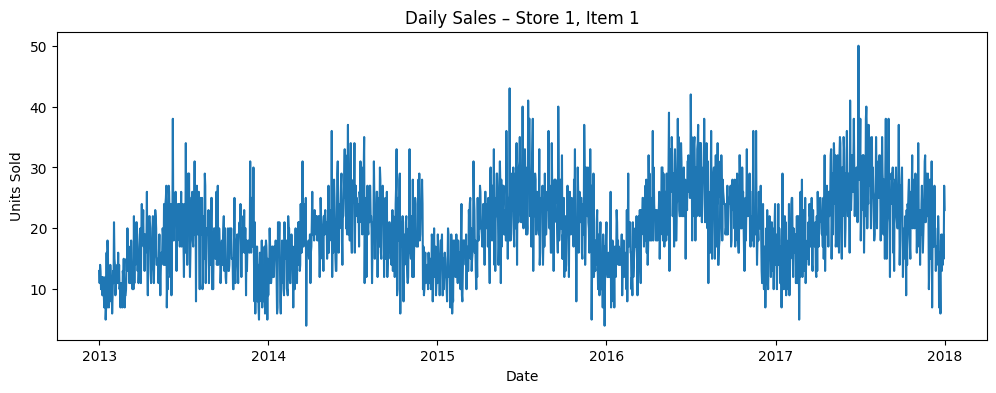

In [22]:
plt.figure(figsize=(12,4))
plt.plot(sample['date'], sample['sales'])
plt.title("Daily Sales – Store 1, Item 1")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.show()

In [23]:
df['dayofweek'] = df['date'].dt.dayofweek
df['week'] = df['date'].dt.isocalendar().week.astype(int)
df['month'] = df['date'].dt.month

In [24]:
df['lag_1'] = df.groupby(['store', 'item'])['sales'].shift(1)
df['lag_7'] = df.groupby(['store', 'item'])['sales'].shift(7)
df['lag_14'] = df.groupby(['store', 'item'])['sales'].shift(14)

In [25]:
df['rolling_mean_7'] = (
    df.groupby(['store', 'item'])['sales']
      .shift(1)
      .rolling(7)
      .mean()
)

df['rolling_std_7'] = (
    df.groupby(['store', 'item'])['sales']
      .shift(1)
      .rolling(7)
      .std()
)

In [26]:
df = df.dropna()

In [27]:
df[['sales','lag_1','lag_7','rolling_mean_7']].head()

,sales,lag_1,lag_7,rolling_mean_7
14,5,12.0,9.0,9.714286
15,7,5.0,12.0,9.142857
16,16,7.0,9.0,8.428571
17,7,16.0,9.0,9.428571
18,18,7.0,7.0,9.142857


In [28]:
split_date = df['date'].quantile(0.8)

train = df[df['date'] <= split_date]
test  = df[df['date'] > split_date]

train.shape, test.shape

((725000, 12), (181000, 12))

In [29]:
features = [
    'lag_1', 'lag_7', 'lag_14',
    'rolling_mean_7', 'rolling_std_7',
    'dayofweek', 'week', 'month'
]

X_train = train[features]
y_train = train['sales']

X_test = test[features]
y_test = test['sales']

In [30]:
# Baseline: predict using yesterday's sales
baseline_preds = X_test['lag_1']

In [31]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

baseline_mae = mean_absolute_error(y_test, baseline_preds)
baseline_mse = mean_squared_error(y_test, baseline_preds)
baseline_rmse = np.sqrt(baseline_mse)

baseline_mae, baseline_rmse

(11.250618784530387, np.float64(15.40109022473725))

In [32]:
baseline_mse >= 0

True

In [33]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [34]:
lr_preds = lr.predict(X_test)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr_mae = mean_absolute_error(y_test, lr_preds)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_preds))

lr_mae, lr_rmse

(6.988129899688553, np.float64(9.136109448077104))

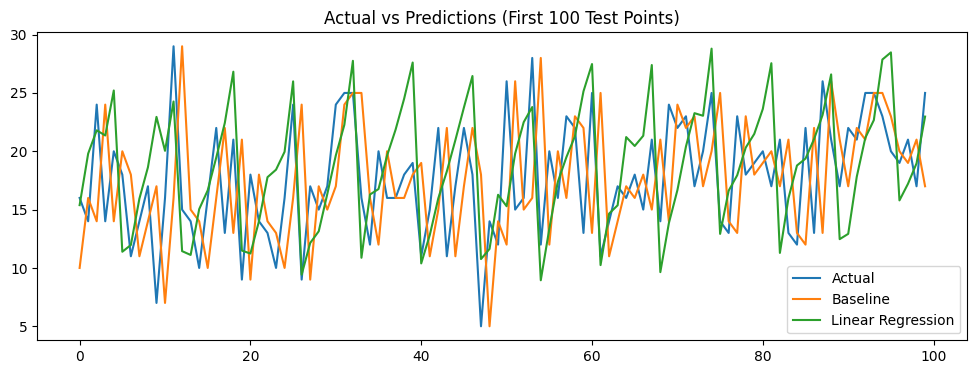

In [36]:
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:100], label='Actual')
plt.plot(baseline_preds.values[:100], label='Baseline')
plt.plot(lr_preds[:100], label='Linear Regression')
plt.legend()
plt.title("Actual vs Predictions (First 100 Test Points)")
plt.show()

In [37]:
from xgboost import XGBRegressor
print("XGBoost import successful")

XGBoost import successful


In [38]:
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

In [39]:
xgb.fit(X_train, y_train)

,"objective objective: str | xgboost.sklearn._SklObjWProto | typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]] | NoneSpecify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: float | typing.List[float] | NoneThe initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.List[xgboost.callback.TrainingCallback] | NoneList of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: float | NoneSubsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: float | NoneSubsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: float | NoneSubsample ratio of columns when constructing each tree.,0.8
,"device device: str | None.. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: int | None.. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: str | typing.List[str | typing.Callable] | typing.Callable | None.. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes from sklearn.metrics import mean_absolute_error X, y = load_diabetes(return_X_y=True) reg = xgb.XGBRegressor( tree_meth

In [40]:
xgb_preds = xgb.predict(X_test)

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))

xgb_mae, xgb_rmse

(6.37864351272583, np.float64(8.291596020983857))

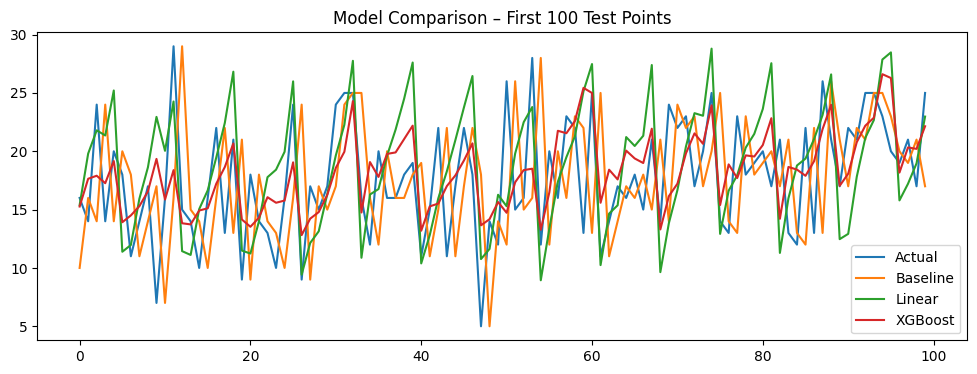

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_test.values[:100], label="Actual")
plt.plot(baseline_preds.values[:100], label="Baseline")
plt.plot(lr_preds[:100], label="Linear")
plt.plot(xgb_preds[:100], label="XGBoost")
plt.legend()
plt.title("Model Comparison – First 100 Test Points")
plt.show()

In [44]:
import os

os.makedirs("../models", exist_ok=True)

In [45]:
import joblib

joblib.dump(xgb, "../models/xgboost_demand_forecaster.pkl")

['../models/xgboost_demand_forecaster.pkl']

In [46]:
os.listdir("../models")

['xgboost_demand_forecaster.pkl']

In [47]:
results = X_test.copy()
results['actual_sales'] = y_test.values
results['predicted_sales'] = xgb_preds

In [48]:
safety_stock = xgb_rmse  # using model uncertainty

In [49]:
results['recommended_inventory'] = (
    results['predicted_sales'] + safety_stock
).round()

In [50]:
UNDERSTOCK_COST = 10   # lost profit per unit
OVERSTOCK_COST = 2    # holding cost per unit

In [51]:
results['understock_units'] = np.maximum(
    results['actual_sales'] - results['recommended_inventory'], 0
)

results['overstock_units'] = np.maximum(
    results['recommended_inventory'] - results['actual_sales'], 0
)

results['total_cost'] = (
    results['understock_units'] * UNDERSTOCK_COST +
    results['overstock_units'] * OVERSTOCK_COST
)

In [52]:
results['naive_inventory'] = results['lag_1']

results['naive_cost'] = (
    np.maximum(results['actual_sales'] - results['naive_inventory'], 0) * UNDERSTOCK_COST +
    np.maximum(results['naive_inventory'] - results['actual_sales'], 0) * OVERSTOCK_COST
)

In [53]:
results[['total_cost', 'naive_cost']].sum()

total_cost     4629556.0
naive_cost    12249252.0
dtype: float64

In [54]:
cost_reduction = (
    1 - results['total_cost'].sum() / results['naive_cost'].sum()
) * 100

cost_reduction

np.float64(62.20539833779238)